In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
patchesfile='../../data/tiles/tiles_461.thr_extracted.pkl'

In [3]:
# %load ../scripts/lib/shape_utils.py

import psutil
from os import system
from subprocess import Popen,PIPE
from time import time

import numpy as np
from numpy import sqrt, mean
from subprocess import Popen,PIPE
from os import system
from os.path import isfile,getmtime

import cv2

import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel,convolve

import yaml

class configuration():
    def __init__(self,yamlFile):
        self.D=yaml.load(open(yamlFile,'r'))

    def getParams(self):
        return self.D

def run(command):
    print('cmd=',command)
    system(command)
    
def runPipe(command):
    print('runPipe cmd=',command)
    p=Popen(command.split(),stdout=PIPE,stderr=PIPE)
    L=p.communicate()
    stdout=L[0].decode("utf-8").split('\n')
    stderr=L[1].decode("utf-8").split('\n')
    return stdout,stderr

time_log=[]
def clock(message):
    print('%8.1f \t%s'%(time(),message))
    time_log.append((time(),message))

def printClock():
    t=time_log[0][0]
    for i in range(1,len(time_log)):
        print('%8.1f \t%s'%(time_log[i][0]-t,time_log[i][1]))
        t=time_log[i][0]

def list_s3_files(stack_directory):
    stdout,stderr=runPipe("aws s3 ls %s/ "%(stack_directory))
    filenames=[]
    for line in stdout:
        parts=line.strip().split()
        if len(parts)!=4:
            continue
        filenames.append(parts[-1])
    return filenames

def read_files(s3_dir,_delete=False,data_dir='/dev/shm/data/'):
    s3files=list_s3_files(s3_dir)
    for filename in s3files:
        if not isfile(data_dir+'/'+filename):
            run('aws s3 cp %s/%s %s'%(s3_dir,filename,data_dir))
        D=fromfile(data_dir+'/'+filename,dtype=np.float16)
        pics=D.reshape([-1,_size,_size])
        if _delete:
            run('rm %s/%s'%(data_dir,filename))
        yield pics

def data_stream(s3_dir='s3://mousebraindata-open/MD657/permuted'):
    for pics in read_files(s3_dir):
        j=0
        for i in range(pics.shape[0]):
            if j%1000==0:
                print('\r examples read=%10d'%j,end='')
            j+=1    
            yield pics[i,:,:]


def Last_Modified(file_name):
    try:
        mtime = getmtime(file_name)
    except OSError:
        mtime = 0
    return(mtime)
            
def calc_err(pic,gaussian = None):
    if gaussian is None:
        gaussian=Gaussian2DKernel(1,x_size=7,y_size=7)
    factor=np.sum(gaussian)
    P=convolve(pic,gaussian)/factor
    #except:
    #    print('err in calc_err/convolve',pic.shape,gaussian.shape,factor)
    #    P=pic
    error=sqrt(mean(abs(pic-P)))
    sub=P[::2,::2]
    return error,sub

def plot_patches(fig,data,h=15,w=15,_titles=[]):
    for i in range(h*w):
        if i>=data.shape[0]:
            break
        ax=fig.add_subplot(h,w,i+1);
        pic=np.array(data[i,:,:],dtype=np.float32)

        subfig=ax.imshow(pic,cmap='gray')
        if(len(_titles)>i):
            plt.title(_titles[i])
        subfig.axes.get_xaxis().set_visible(False)
        subfig.axes.get_yaxis().set_visible(False)

def pack_pics(Reps):
    size=Reps[0].shape[0]
    _len=len(Reps)
    Reps_mat=np.zeros([_len,size,size])
    for i in range(_len):
        Reps_mat[i,:,:]=Reps[i]
    return Reps_mat

def dist2(a,b):
    diff=(a-b)**2
    return np.sum(diff.flatten())

def dist_hist(data):
    D=[]
    for i in range(1,data.shape[0]):
        D.append(dist2(data[i,:,:],data[i-1,:,:]))
        if i%1000==0:
            print('\r',i,end='')
    hist(D,bins=100);


def mark_contours(D,tile):

    image = np.array(tile,dtype=np.uint8)
    kernel = np.ones((3,3),np.uint8)
    boundary=np.zeros(image.shape,np.uint8)
    repress=boundary.copy()
    #print('shape of boundary=',boundary.shape)
    _shape=D[0]['mask'].shape
    left=int(_shape[0]/2)
    right=_shape[0]-left
    left,right

    for R in D:
        #compute contour
        color=np.array([0,0,0],dtype=np.uint8)
        color[R['j'] % 2]=255
        mask=np.array(R['mask']*1,dtype=np.uint8)
        dilated = cv2.dilate(mask,kernel,iterations = 1)
        contour = dilated-mask
        #mark contour in ln image coordinates
        coor=[R['Y'],R['X']]

        boundary[coor[0]-left:coor[0]+right,coor[1]-left:coor[1]+right]\
        +=np.multiply.outer(contour,color)
        repress[coor[0]-left:coor[0]+right,coor[1]-left:coor[1]+right]\
        +=np.multiply.outer(contour,np.array([1,1,1],dtype=np.uint8))

    combined=image.copy()
    combined[repress==1]=255
    # combined +=boundary

    return combined


In [5]:
patchesfile

'../../data/tiles/tiles_461.thr_extracted.pkl'

In [311]:
%%writefile ../scripts/patch_normalizer.py
import cv2
from cv2 import moments,HuMoments
from skimage.measure import label
import pickle
import numpy as np
#from lib.shape_utils import find_threshold

class normalizer:
    """ a class for normalizing patches """
    def __init__(self,params):
        """        Initialize a Normalizer
        create a circular mask of a given size, size must be an odd number.

        :param params
        """
        self.params=params
        
    def circle_patch(self,radius):
        size=2*radius+1
        x=np.arange(-radius,radius+1)
        xx=np.array([x for i in x])
        yy=xx.T
        d=np.sqrt(xx**2+yy**2)
        return np.array((d<radius+0.1)*1,dtype=np.uint8)

    def set_mask(self,radius):
        print('set mask, radius=',radius)
        self.mask = self.circle_patch(radius)
        self.center=int(radius)
        self.size=2*radius+1
        
    def normalize_greyvals(self,ex):
        """normalize the grey-values of a patch so the the mean is zero and the std is 1.
        :param ex:  patch
        :returns: 
        * patch: normalized pattch: numpy 2D array
        * dict: a dictionary of values associated with normalizing the patch
        """
        _flat=ex.flatten()
        _m=np.mean(_flat)
        _m2=np.mean(_flat**2)
        if _m2>_m**2:
            _std=np.sqrt(_m2-_m**2)
        else:
            _std=1
            print('error in calc of _std',_m,_m2)

        Dict={
            'mean':_m,
            'std':_std
        }

        ex_new=ex/_std
        return ex_new,Dict

    
    def angle(self,ex):
        """compute the rotation angle of a patch

        :param ex: 
        :returns: 
        :rtype: 

        """
        M=moments(ex)
        #print(M['m00'],M['m10'],M['m01'])
        x=M['m10']/M['m00']
        y=M['m01']/M['m00']
        nu20=(M['m20']/M['m00'])-x**2
        nu02=(M['m02']/M['m00'])-y**2
        nu11=(M['m11']/M['m00'])-y*x
        confidence=0
        if nu11!=0:
            confidence =np.abs((nu20-nu02)/nu11)  # the confidence number
                                              # is small if small
                                              # changes to the moments
                                              # will generate a
                                              # different angle
                                              # estimate

        ang_est=0
        if confidence > 0.1:
            ang_est=-np.arctan(2*nu11/(nu20-nu02))/np.pi+0.5

        if ang_est>0.5:
            ang_est-=1
        ang180=(ang_est+(np.sign(nu11))/2)*90

        if ang180>=180:
            ang180-=360
        if ang180<-180:
            ang180+=360
        return ang180,confidence

    def flipOrNot(self,ex):
        """
        decide using the moments whether to flip the image.
        :param ex: 
        :returns: 
        :rtype: 

        """
        M=moments(ex)
        x=M['m10']/M['m00'] - self.center
        y=M['m01']/M['m00'] - self.center
        if abs(x)>abs(y):
            return x<0
        else:
            return y<0

    def normalize_angle(self,ex):
        """ place patch in a normalized angle

        :param ex: patch
        :returns: angle, angle and confidence
        :rtype: 

        """
        ang,conf=self.angle(ex)
        M = cv2.getRotationMatrix2D((self.center,self.center),-ang,1)
        dst= cv2.warpAffine(ex,M,(self.size,self.size))*self.mask
        if self.flipOrNot(dst):
            M180 = cv2.getRotationMatrix2D((self.center,self.center),180,1)
            dst = cv2.warpAffine(dst,M180,(self.size,self.size))

        return ang,conf,dst*self.mask

    # normalized_patch,rotation,confidence=Norm.
    def put_in_circle(self,ex):
        M=moments(ex)
        #print(M['m00'],M['m10'],M['m01'])
        x=M['m10']/M['m00']
        y=M['m01']/M['m00']

        x=round(x)
        y=round(y)
        w=prop['width']
        h=prop['height']
        x,y,h,w
        xc=w-x
        yc=h-y
        radius=int(ceil(sqrt(np.max([(x*x+y*y),(xc*xc+y*y),(x*x+yc*yc),(xc*xc+yc*yc)]))))
        self.set_mask(radius)
        size=2*radius+1
        circ_patch=np.zeros([size,size])
        x1=int(radius-x)
        x2=x1+w
        y1=int(radius-y)
        y2=y1+h
        circ_patch[y1:y2,x1:x2]=ex
        return circ_patch

    def normalize_patch(self,ex):
        ex_in_circle = self.put_in_circle(copy(ex))
        #normalize patch interms of grey values and in terms of rotation
        ex_grey_normed,grey_level_stats=self.normalize_greyvals(copy(ex_in_circle))

        #normalize angle
        rot_angle1,conf1,ex_rotation_normed=self.normalize_angle(copy(ex_grey_normed))
        rot_angle2,conf2,ex_rotation_normed=self.normalize_angle(copy(ex_rotation_normed))
        total_rotation = rot_angle1+rot_angle2
        confidence=conf2
        normalized_patch =  ex_rotation_normed*self.mask
        Dict={
            'original_patch':ex,
            'patch_in_circle':ex_in_circle,
            'ex_grey_normed':ex_grey_normed,
            'normalized_patch':normalized_patch,
            'rotation':total_rotation,
            'rotation_confidence':confidence
        }
        Dict.update(grey_level_stats)

        return Dict

Overwriting ../scripts/patch_normalizer.py


In [299]:
import pickle as pkl
L=pkl.load(open(patchesfile,'rb'))

In [300]:
len(L)

687

366


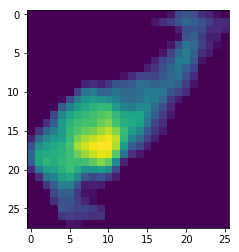

In [307]:
params = configuration('../scripts/shape_params.yaml').getParams()
Norm=normalizer(params)
for i in range(len(L)):
    ex,prop=L[i]

    if prop['area']>250 and prop['area']<300 and i>360:
        print(i)
        break
imshow(ex)


In [308]:
Normalized=Norm.normalize_patch(ex)

set mask, radius= 22


In [309]:
Normalized.keys()

dict_keys(['original_patch', 'patch_in_circle', 'ex_grey_normed', 'normalized_patch', 'rotation', 'rotation_confidence', 'global mean', 'global std'])

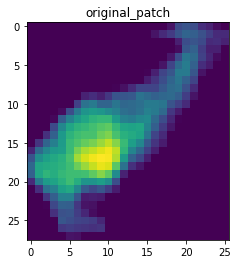

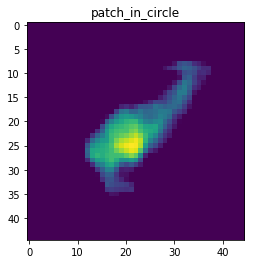

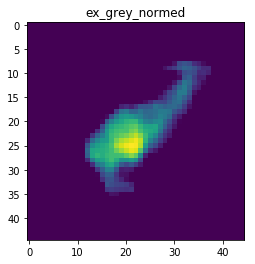

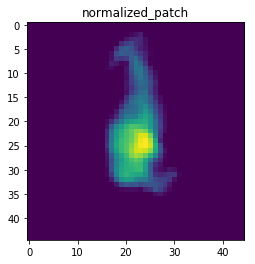

In [310]:

for key in ['original_patch', 'patch_in_circle', 'ex_grey_normed', 'normalized_patch']:
    patch=Normalized[key]
    figure()
    imshow(patch)
    title(key)

In [236]:
np.max(npatch.flatten())

5.991881697398422

In [306]:
type(npatch[0,0])

numpy.float64